<a href="https://colab.research.google.com/github/arimbawa/Big-Data/blob/main/09_Pyspark_Mlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,413 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,288 kB]
Get:14 https://r

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
import random

# ===============================================================
# 1. Inisialisasi Spark
# ===============================================================
spark = SparkSession.builder.appName("IoT_Classification_Regression_Clustering").getOrCreate()

# ===============================================================
# 2. Membuat Data Acak (Sensor IoT)
# ===============================================================
random.seed(42)
data = []
for i in range(100):
    temp = random.uniform(25, 40)             # suhu dalam °C
    humidity = random.uniform(30, 90)         # kelembaban %
    vibration = random.uniform(0.1, 5.0)      # getaran sensor
    # label_class = 1 jika suhu tinggi + getaran besar + lembab tinggi → indikasi bocor
    label_class = 1 if (temp > 33 and humidity > 60 and vibration > 3.0) else 0
    # label_reg = debit air (L/min), semakin tinggi suhu dan getaran → debit cenderung menurun
    label_reg = max(0, 100 - (temp*1.5 + vibration*5 + (90 - humidity)*0.3))
    data.append((temp, humidity, vibration, label_class, label_reg))

columns = ["temp", "humidity", "vibration", "label_class", "label_reg"]
df = spark.createDataFrame(data, columns)

print("=== Contoh Data ===")
df.show(5)

# ===============================================================
# 3. Menyiapkan Fitur
# ===============================================================
assembler = VectorAssembler(inputCols=["temp", "humidity", "vibration"], outputCol="features")
df_features = assembler.transform(df)

# ===============================================================
# 4. --- KLASIFIKASI (Decision Tree Classifier) ---
# ===============================================================
print("\n=== KLASIFIKASI: Decision Tree ===")
dt = DecisionTreeClassifier(labelCol="label_class", featuresCol="features", maxDepth=4)
model_class = dt.fit(df_features)
pred_class = model_class.transform(df_features)

# Evaluasi
evaluator_class = MulticlassClassificationEvaluator(labelCol="label_class", predictionCol="prediction", metricName="accuracy")
acc = evaluator_class.evaluate(pred_class)
print(f"Akurasi Klasifikasi: {acc:.3f}")
pred_class.select("temp", "humidity", "vibration", "label_class", "prediction").show(5)

# ===============================================================
# 5. --- REGRESI (Linear Regression) ---
# ===============================================================
print("\n=== REGRESI: Linear Regression ===")
lr = LinearRegression(labelCol="label_reg", featuresCol="features")
model_reg = lr.fit(df_features)
pred_reg = model_reg.transform(df_features)

# Evaluasi
evaluator_reg = RegressionEvaluator(labelCol="label_reg", predictionCol="prediction", metricName="rmse")
rmse = evaluator_reg.evaluate(pred_reg)
print(f"RMSE Regresi: {rmse:.3f}")
pred_reg.select("temp", "humidity", "vibration", "label_reg", "prediction").show(5)

# ===============================================================
# 6. --- CLUSTERING (KMeans) ---
# ===============================================================
print("\n=== CLUSTERING: K-Means ===")
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")
model_cluster = kmeans.fit(df_features)
pred_cluster = model_cluster.transform(df_features)

print(f"Jumlah Cluster: {len(model_cluster.clusterCenters())}")
print("Centroid Cluster:")
for i, center in enumerate(model_cluster.clusterCenters()):
    print(f"Cluster {i}: {center}")

pred_cluster.select("temp", "humidity", "vibration", "cluster").show(5)

# ===============================================================
# 7. Selesai
# ===============================================================
spark.stop()


=== Contoh Data ===
+------------------+------------------+------------------+-----------+------------------+
|              temp|          humidity|         vibration|label_class|         label_reg|
+------------------+------------------+------------------+-----------+------------------+
|34.591401976868255|31.500645313360017|1.4476436600086846|          0|23.324872328662195|
| 28.34816107223234| 74.18827284984074| 3.415827488372266|          0|35.655102804742384|
| 38.38269351557268| 35.21632995776497|2.1674169164578254|          0|15.153774131681331|
|25.446958291571054|43.118278488216205| 2.576240911706476|          0|34.883841550575895|
|25.398039545257955| 41.93025904119891| 3.284433745119664|          0| 31.05984966887442|
+------------------+------------------+------------------+-----------+------------------+
only showing top 5 rows


=== KLASIFIKASI: Decision Tree ===
Akurasi Klasifikasi: 0.990
+------------------+------------------+------------------+-----------+----------+


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

spark = SparkSession.builder.appName("AssociationRuleMining").getOrCreate()

# Contoh dataset transaksi
data = [
    (0, ["air", "sensor", "getaran"]),
    (1, ["sensor", "getaran", "lembab"]),
    (2, ["air", "getaran"]),
    (3, ["sensor", "air", "lembab"]),
    (4, ["getaran", "air", "lembab"])
]

df = spark.createDataFrame(data, ["id", "items"])

# FP-Growth model
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.4, minConfidence=0.6)
model = fpGrowth.fit(df)

# Frequent itemsets
print("Frequent Itemsets:")
model.freqItemsets.show()

# Association Rules
print("Association Rules:")
model.associationRules.show()

# Prediksi item rekomendasi
print("Prediction on new transaction:")
model.transform(spark.createDataFrame([(5, ["sensor", "lembab"])], ["id", "items"])).show()


Frequent Itemsets:
+-----------------+----+
|            items|freq|
+-----------------+----+
|         [sensor]|   3|
|[sensor, getaran]|   2|
|    [sensor, air]|   2|
|            [air]|   4|
|        [getaran]|   4|
|   [getaran, air]|   3|
|         [lembab]|   3|
| [lembab, sensor]|   2|
|[lembab, getaran]|   2|
|    [lembab, air]|   2|
+-----------------+----+

Association Rules:
+----------+----------+------------------+------------------+-------+
|antecedent|consequent|        confidence|              lift|support|
+----------+----------+------------------+------------------+-------+
|  [lembab]|  [sensor]|0.6666666666666666|1.1111111111111112|    0.4|
|  [lembab]| [getaran]|0.6666666666666666|0.8333333333333333|    0.4|
|  [lembab]|     [air]|0.6666666666666666|0.8333333333333333|    0.4|
| [getaran]|     [air]|              0.75|            0.9375|    0.6|
|  [sensor]| [getaran]|0.6666666666666666|0.8333333333333333|    0.4|
|  [sensor]|     [air]|0.6666666666666666|0.8333333

Akurasi Klasifikasi: 0.990
RMSE Regresi: 0.000
Centroid Cluster:
Cluster 0: [32.19831127 83.89032342  2.8377193 ]
Cluster 1: [32.84067929 42.00890113  2.50276003]
Cluster 2: [33.55238068 65.93341364  2.4438675 ]


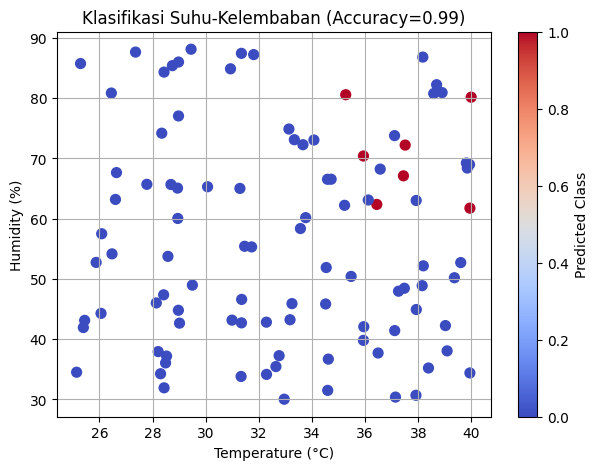

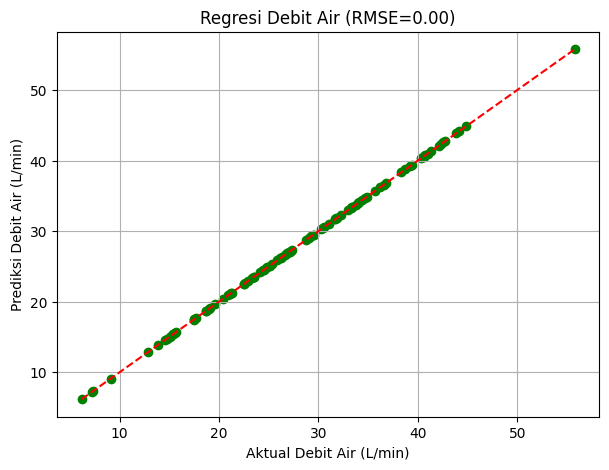

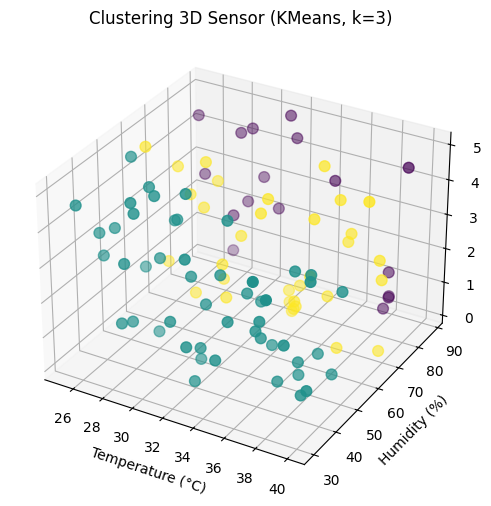

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
import matplotlib.pyplot as plt
import random

# ===============================================================
# 1. Inisialisasi Spark
# ===============================================================
spark = SparkSession.builder.appName("IoT_Vis_PySpark").getOrCreate()

# ===============================================================
# 2. Membuat Data Acak
# ===============================================================
random.seed(42)
data = []
for i in range(100):
    temp = random.uniform(25, 40)
    humidity = random.uniform(30, 90)
    vibration = random.uniform(0.1, 5.0)
    label_class = 1 if (temp > 33 and humidity > 60 and vibration > 3.0) else 0
    label_reg = max(0, 100 - (temp*1.5 + vibration*5 + (90 - humidity)*0.3))
    data.append((temp, humidity, vibration, label_class, label_reg))

columns = ["temp", "humidity", "vibration", "label_class", "label_reg"]
df = spark.createDataFrame(data, columns)

assembler = VectorAssembler(inputCols=["temp", "humidity", "vibration"], outputCol="features")
df_features = assembler.transform(df)

# ===============================================================
# 3. KLASIFIKASI
# ===============================================================
dt = DecisionTreeClassifier(labelCol="label_class", featuresCol="features", maxDepth=4)
model_class = dt.fit(df_features)
pred_class = model_class.transform(df_features)

evaluator_class = MulticlassClassificationEvaluator(labelCol="label_class", predictionCol="prediction", metricName="accuracy")
acc = evaluator_class.evaluate(pred_class)
print(f"Akurasi Klasifikasi: {acc:.3f}")

# ===============================================================
# 4. REGRESI
# ===============================================================
lr = LinearRegression(labelCol="label_reg", featuresCol="features")
model_reg = lr.fit(df_features)
pred_reg = model_reg.transform(df_features)

evaluator_reg = RegressionEvaluator(labelCol="label_reg", predictionCol="prediction", metricName="rmse")
rmse = evaluator_reg.evaluate(pred_reg)
print(f"RMSE Regresi: {rmse:.3f}")

# ===============================================================
# 5. CLUSTERING
# ===============================================================
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")
model_cluster = kmeans.fit(df_features)
pred_cluster = model_cluster.transform(df_features)

print("Centroid Cluster:")
for i, center in enumerate(model_cluster.clusterCenters()):
    print(f"Cluster {i}: {center}")

# ===============================================================
# 6. Konversi ke Pandas untuk Visualisasi
# ===============================================================
pdf_class = pred_class.select("temp", "humidity", "vibration", "label_class", "prediction").toPandas()
pdf_reg = pred_reg.select("temp", "humidity", "vibration", "label_reg", "prediction").toPandas()
pdf_cluster = pred_cluster.select("temp", "humidity", "vibration", "cluster").toPandas()

# ===============================================================
# 7. Visualisasi Klasifikasi (2D)
# ===============================================================
plt.figure(figsize=(7,5))
plt.scatter(pdf_class["temp"], pdf_class["humidity"], c=pdf_class["prediction"], cmap="coolwarm", s=50)
plt.title(f"Klasifikasi Suhu-Kelembaban (Accuracy={acc:.2f})")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.colorbar(label="Predicted Class")
plt.grid(True)
plt.show()

# ===============================================================
# 8. Visualisasi Regresi (Aktual vs Prediksi)
# ===============================================================
plt.figure(figsize=(7,5))
plt.scatter(pdf_reg["label_reg"], pdf_reg["prediction"], c="green")
plt.plot([pdf_reg["label_reg"].min(), pdf_reg["label_reg"].max()],
         [pdf_reg["label_reg"].min(), pdf_reg["label_reg"].max()], "r--")
plt.title(f"Regresi Debit Air (RMSE={rmse:.2f})")
plt.xlabel("Aktual Debit Air (L/min)")
plt.ylabel("Prediksi Debit Air (L/min)")
plt.grid(True)
plt.show()

# ===============================================================
# 9. Visualisasi Clustering (3D)
# ===============================================================
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pdf_cluster["temp"], pdf_cluster["humidity"], pdf_cluster["vibration"],
           c=pdf_cluster["cluster"], cmap="viridis", s=60)
ax.set_title("Clustering 3D Sensor (KMeans, k=3)")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Humidity (%)")
ax.set_zlabel("Vibration (m/s²)")
plt.show()

# ===============================================================
# 10. Selesai
# ===============================================================
spark.stop()
